# **PROJECT NAME:** Time-Series Forecasting — TSLA Close
**Goal:** Forecast next-day **Close** with two approaches:
1) **PMDARIMA (auto_arima)** — classical, univariate  
2) **LSTM** — simple deep model on past windows (returns)

**Evaluation:** Rolling (walk-forward) 1-step-ahead; metrics **RMSE, MAPE**; comparison plot + table.



## 1. Importing libraries, Install Packages & Loading the Dataset

In [1]:
!pip cache purge -q
!pip uninstall -y -q numpy pandas scipy scikit-learn statsmodels pmdarima matplotlib seaborn joblib


In [ ]:
!pip install -q --no-cache-dir \
  "numpy==1.26.4" \
  "pandas==2.2.2" \
  "scipy==1.11.4" \
  "scikit-learn==1.4.2" \
  "statsmodels==0.14.2" \
  "pmdarima==2.0.4" \
  "matplotlib==3.8.4" \
  "seaborn==0.13.2" \
  "joblib==1.4.2"


In [4]:
import warnings, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (12,4)
plt.rcParams["axes.grid"] = True

SEED = 42
rng = np.random.RandomState(SEED)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    return float(np.sqrt(np.mean((y_true - y_pred)**2)))

def mape(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    eps = 1e-8
    return float(np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100.0)


In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Path in Google Drive
CSV_PATH = "/content/drive/MyDrive/Datasets/tsla_2025.csv"

df = pd.read_csv(CSV_PATH)
assert "Date" in df.columns and "Close" in df.columns, "CSV must have Date and Close columns."

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").set_index("Date")

# Univariate series for modeling
ts = df[["Close"]].rename(columns={"Close": "y"})
ts.index.name = "ds"

print("Rows:", len(ts), "| Range:", ts.index.min().date(), "→", ts.index.max().date())
ts.head()


Rows: 3663 | Range: 2010-06-28 → 2025-01-17


,y
ds,
2010-06-28,1.13333
2010-06-29,1.59267
2010-06-30,1.58867
2010-07-01,1.46400
2010-07-02,1.28000


## 2. Data PreProcessing & Quick EDA
- Look at head/tail, missing values and stats
- Plot Close over time
- Check daily returns distribution


In [7]:
display(ts.head())
display(ts.tail())
print("Missing values in y:", int(ts["y"].isna().sum()))
display(ts.describe())


,y
ds,
2010-06-28,1.13333
2010-06-29,1.59267
2010-06-30,1.58867
2010-07-01,1.46400
2010-07-02,1.28000


,y
ds,
2025-01-13,403.31
2025-01-14,396.36
2025-01-15,428.22
2025-01-16,413.82
2025-01-17,426.50


Missing values in y: 0


,y
count,3663.000000
mean,82.495136
std,108.907286
min,1.053330
25%,12.138000
50%,17.980000
75%,179.825000
max,479.860000


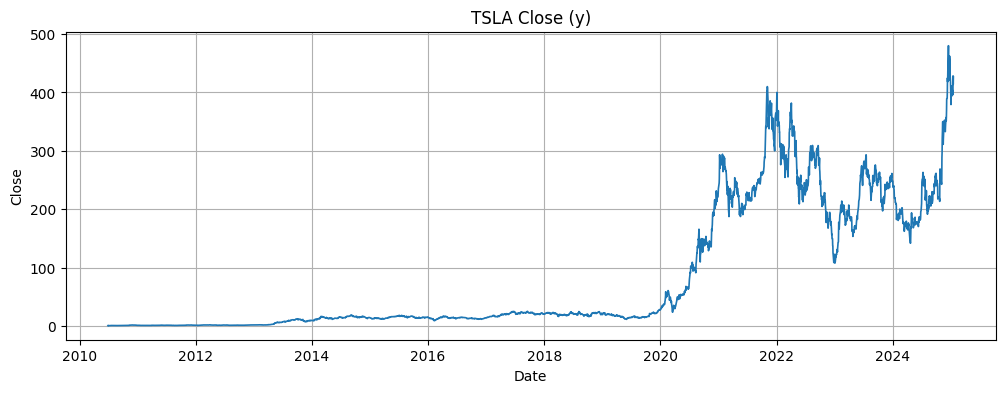

In [8]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(ts.index, ts["y"], lw=1.2)
ax.set_title("TSLA Close (y)")
ax.set_xlabel("Date"); ax.set_ylabel("Close")
plt.show()


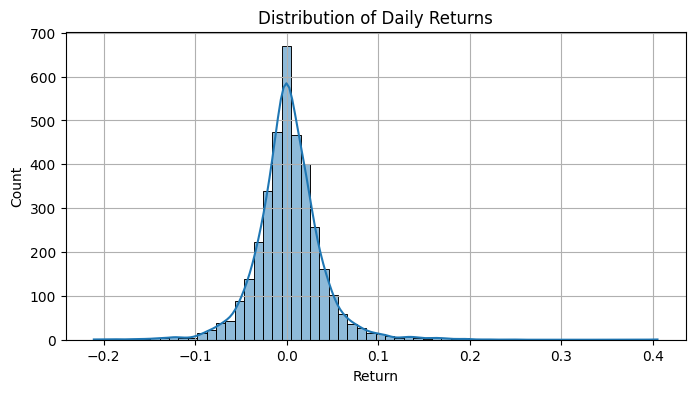

Return mean: 0.0022884267473423626 | Return std: 0.036785173481046124


In [9]:
rets = ts["y"].pct_change().dropna().rename("ret")

fig, ax = plt.subplots(figsize=(8,4))
sns.histplot(rets, bins=60, kde=True, ax=ax)
ax.set_title("Distribution of Daily Returns")
ax.set_xlabel("Return")
plt.show()

print("Return mean:", rets.mean(), "| Return std:", rets.std())



## 3. Split & evaluation
- Split into train/val/test (70/15/15)
- Evaluate step by step (predict next day, reveal actual, move forward)
- Start with a simple naive baseline (yesterday = today)


In [10]:
def time_split_index(idx, train=0.7, val=0.15):
    n = len(idx)
    train_end = int(n * train)
    val_end = int(n * (train + val))
    return idx[:train_end], idx[train_end:val_end], idx[val_end:]

train_idx, val_idx, test_idx = time_split_index(ts.index, train=0.70, val=0.15)

y_train = ts.loc[train_idx, "y"]
y_val   = ts.loc[val_idx,   "y"]
y_test  = ts.loc[test_idx,  "y"]

print("Train:", train_idx[0].date(), "→", train_idx[-1].date(), "| n =", len(train_idx))
print("Val  :", val_idx[0].date(),   "→", val_idx[-1].date(),   "| n =", len(val_idx))
print("Test :", test_idx[0].date(),  "→", test_idx[-1].date(),  "| n =", len(test_idx))


Train: 2010-06-28 → 2020-09-02 | n = 2564
Val  : 2020-09-03 → 2022-11-07 | n = 549
Test : 2022-11-08 → 2025-01-17 | n = 550


Naive baseline — VAL: RMSE= 10.107 | MAPE= 2.899 %
Naive baseline — TEST: RMSE= 8.844 | MAPE= 2.77 %


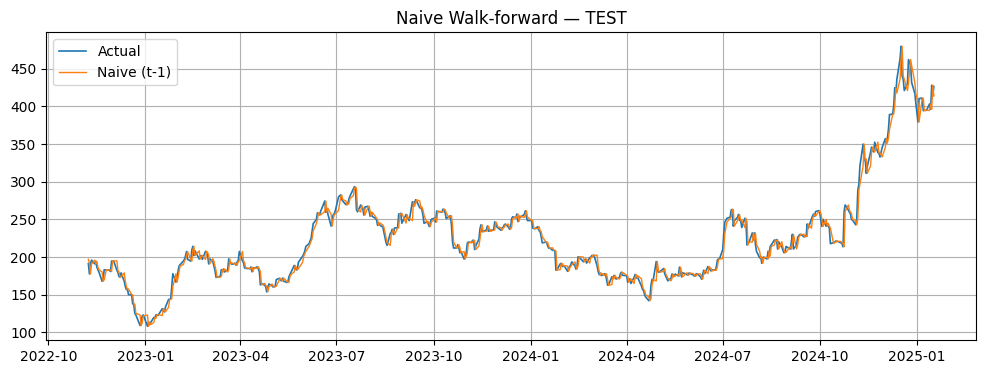

In [11]:
def rolling_naive(previous_last, future_series):
    preds = []
    last = previous_last
    for actual in future_series:
        preds.append(last)
        last = actual
    return np.array(preds)

val_pred_naive  = rolling_naive(y_train.iloc[-1], y_val.values)
test_pred_naive = rolling_naive(y_val.iloc[-1],   y_test.values)

print("Naive baseline — VAL:",
      "RMSE=", round(rmse(y_val.values,  val_pred_naive), 3),
      "| MAPE=", round(mape(y_val.values, val_pred_naive), 3), "%")

print("Naive baseline — TEST:",
      "RMSE=", round(rmse(y_test.values, test_pred_naive), 3),
      "| MAPE=", round(mape(y_test.values, test_pred_naive), 3), "%")

# Plot baseline on test
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(test_idx, y_test.values, label="Actual", lw=1.2)
ax.plot(test_idx, test_pred_naive, label="Naive (t-1)", lw=1.0)
ax.set_title("Naive Walk-forward — TEST")
ax.legend()
plt.show()


## 4. PMDARIMA (Auto ARIMA)
- Automatically picks ARIMA order
- Trained on train set, then tested step by step (walk-forward)
- Same style as naive, but with more parameters


In [12]:
import pmdarima as pm

In [13]:
# Fit ARIMA on training set (Close series only)
arima_model = pm.auto_arima(
    y_train,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=False
)

print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2564
Model:               SARIMAX(5, 2, 5)   Log Likelihood               -3658.447
Date:                Fri, 03 Oct 2025   AIC                           7338.893
Time:                        19:20:34   BIC                           7403.227
Sample:                             0   HQIC                          7362.221
                               - 2564                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8167      0.015   -117.863      0.000      -1.847      -1.786
ar.L2         -2.0936      0.033    -63.882      0.000      -2.158      -2.029
ar.L3         -1.0449      0.039    -26.678      0.0

In [15]:
def rolling_forecast_arima_np(y_train_ser, y_future_ser, fitted_model):

    # Make sure we operate on numpy arrays (no datetime index involved)
    y_tr = np.asarray(y_train_ser, dtype=float)
    y_fu = np.asarray(y_future_ser, dtype=float)

    # Clone the fitted model so original isn't mutated (optional but safer)
    # Some versions of pmdarima don't expose a direct clone; refit on y_tr instead:
    model = pm.ARIMA(order=fitted_model.order, seasonal_order=fitted_model.seasonal_order,
                     suppress_warnings=True, error_action="ignore")
    model.fit(y_tr)

    preds = np.empty_like(y_fu, dtype=float)
    for i, actual in enumerate(y_fu):
        # 1-step forecast
        yhat = model.predict(n_periods=1)
        preds[i] = float(yhat[0])

        # update with the true observation (as a 1-length array/list)
        model.update([float(actual)])

    return preds

# ---- Validation walk-forward
val_pred_arima = rolling_forecast_arima_np(y_train, y_val, arima_model)

print("ARIMA — VAL:",
      "RMSE=", round(rmse(y_val.values,  val_pred_arima), 3),
      "| MAPE=", round(mape(y_val.values, val_pred_arima), 3), "%")

# ---- Refit on Train+Val, then walk-forward on TEST
arima_model_full = pm.auto_arima(
    pd.concat([y_train, y_val]),
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    trace=False
)

test_pred_arima = rolling_forecast_arima_np(pd.concat([y_train, y_val]), y_test, arima_model_full)

print("ARIMA — TEST:",
      "RMSE=", round(rmse(y_test.values, test_pred_arima), 3),
      "| MAPE=", round(mape(y_test.values, test_pred_arima), 3), "%")

# # ---- Plots
# fig, ax = plt.subplots(figsize=(12,4))
# ax.plot(val_idx, y_val.values, label="Actual", lw=1.2)
# ax.plot(val_idx, val_pred_arima, label="ARIMA forecast", lw=1.0)
# ax.set_title("ARIMA Walk-forward — VAL")
# ax.legend(); plt.show()

# fig, ax = plt.subplots(figsize=(12,4))
# ax.plot(test_idx, y_test.values, label="Actual", lw=1.2)
# ax.plot(test_idx, test_pred_arima, label="ARIMA forecast", lw=1.0)
# ax.set_title("ARIMA Walk-forward — TEST")
# ax.legend(); plt.show()


ARIMA — VAL: RMSE= 10.278 | MAPE= 2.976 %
ARIMA — TEST: RMSE= 8.854 | MAPE= 2.771 %


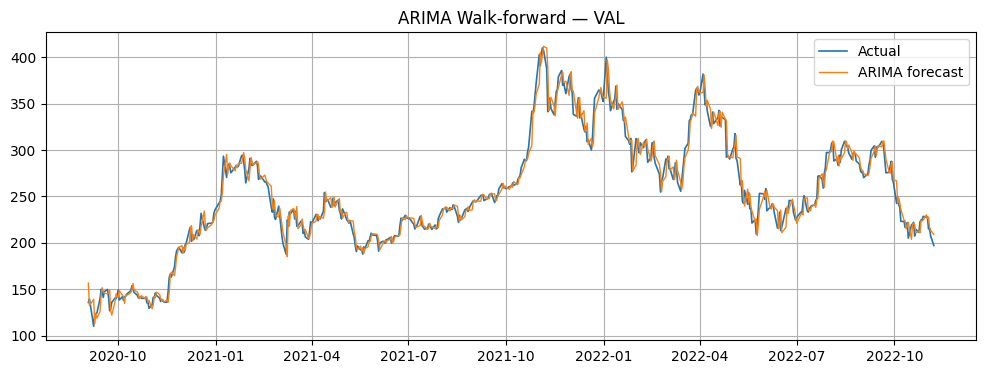

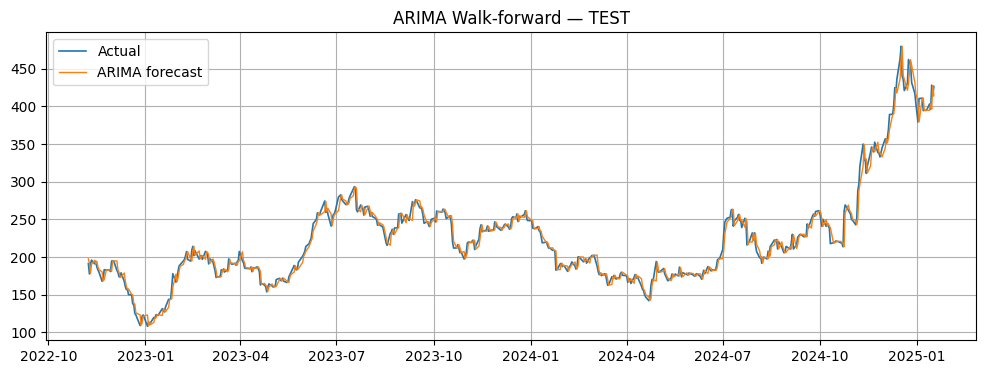

In [16]:
# Plot on VAL
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(val_idx, y_val.values, label="Actual", lw=1.2)
ax.plot(val_idx, val_pred_arima, label="ARIMA forecast", lw=1.0)
ax.set_title("ARIMA Walk-forward — VAL")
ax.legend()
plt.show()

# Plot on TEST
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(test_idx, y_test.values, label="Actual", lw=1.2)
ax.plot(test_idx, test_pred_arima, label="ARIMA forecast", lw=1.0)
ax.set_title("ARIMA Walk-forward — TEST")
ax.legend()
plt.show()


In [17]:
# Make DataFrame with Actual vs ARIMA Predicted prices on TEST set
arima_vs_actual = pd.DataFrame({
    "Actual_Close": y_test.values,
    "ARIMA_Predicted": test_pred_arima
}, index=y_test.index)

arima_vs_actual = arima_vs_actual.round(2)

# Show first 10 rows
print(arima_vs_actual.head(10))
# arima_vs_actual.to_csv("arima_vs_actual.csv")


            Actual_Close  ARIMA_Predicted
ds                                       
2022-11-08        191.30           197.58
2022-11-09        177.59           191.60
2022-11-10        190.72           178.19
2022-11-11        195.97           190.23
2022-11-14        190.95           195.82
2022-11-15        194.42           191.22
2022-11-16        186.92           194.34
2022-11-17        183.17           187.30
2022-11-18        180.19           183.39
2022-11-21        167.87           180.37


## 5. LSTM
- Use daily returns (more stable than raw prices)
- Window of last 30 returns → predict next return
- Convert predicted return back to price
- Evaluate step by step (walk-forward)
### Why returns, not raw price?
- Raw prices keep trending, harder for models
- Returns are steadier around zero
- Easy to convert back to price


In [18]:
import importlib
if importlib.util.find_spec("tensorflow") is None:
    %pip install -q tensorflow==2.16.1
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [19]:
# Build returns from Close (y)
rets_full = ts["y"].pct_change().dropna().rename("ret")

# Align splits using existing date ranges
rets_train = rets_full.loc[rets_full.index.intersection(y_train.index)]
rets_val   = rets_full.loc[rets_full.index.intersection(y_val.index)]
rets_test  = rets_full.loc[rets_full.index.intersection(y_test.index)]

def make_windows_1d(series: np.ndarray, lookback: int):

    X, y = [], []
    for i in range(lookback, len(series)):
        X.append(series[i - lookback:i])
        y.append(series[i])
    X = np.asarray(X, dtype="float32")[..., None]
    y = np.asarray(y, dtype="float32")
    return X, y

LOOKBACK = 30  # Feel free to try 20/40/60 later

# TRAIN windows on returns
ret_tr = rets_train.values.astype("float32")
X_tr, y_tr = make_windows_1d(ret_tr, LOOKBACK)

# VAL windows: need continuity with last LOOKBACK from train
ret_tr_tail = ret_tr[-LOOKBACK:]
ret_va_ctx = np.concatenate([ret_tr_tail, rets_val.values.astype("float32")])
X_va, y_va = make_windows_1d(ret_va_ctx, LOOKBACK)

# TEST windows: need continuity with last LOOKBACK from train+val
ret_va_ctx_tail = ret_va_ctx[-LOOKBACK:]
ret_te_ctx = np.concatenate([ret_va_ctx_tail, rets_test.values.astype("float32")])
X_te, y_te = make_windows_1d(ret_te_ctx, LOOKBACK)

X_tr.shape, y_tr.shape, X_va.shape, y_va.shape, X_te.shape, y_te.shape


((2533, 30, 1), (2533,), (549, 30, 1), (549,), (550, 30, 1), (550,))

In [28]:
tf.keras.backend.clear_session()

model_lstm = models.Sequential([
    layers.Input(shape=(LOOKBACK, 1)),
    layers.LSTM(32, dropout=0.1, return_sequences=False),
    layers.Dense(1)
])

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="mse")
early = callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

hist = model_lstm.fit(
    X_tr, y_tr,
    validation_data=(X_va, y_va),
    epochs=60,
    batch_size=64,
    verbose=0,
    callbacks=[early]
)

print("Epochs trained:", len(hist.history["loss"]))


Epochs trained: 17


In [29]:
# Rolling prediction of returns with actual-fed context
def rolling_predict_returns(model, init_context_returns: np.ndarray, future_returns: np.ndarray, lookback: int):
    ctx = init_context_returns.astype("float32").copy()
    preds = np.empty_like(future_returns, dtype="float32")
    for i, true_r in enumerate(future_returns.astype("float32")):
        x = ctx.reshape(1, lookback, 1)
        r_hat = float(model.predict(x, verbose=0)[0, 0])
        preds[i] = r_hat
        # Feed actual return to roll forward (deployment style)
        ctx = np.concatenate([ctx[1:], [true_r]])
    return preds

# VAL rolling on returns
init_ctx_val = ret_tr[-LOOKBACK:]
future_val_returns = rets_val.values.astype("float32")
val_pred_ret = rolling_predict_returns(model_lstm, init_ctx_val, future_val_returns, LOOKBACK)

# TEST rolling on returns (context = train+val tail)
full_until_val = np.concatenate([ret_tr, future_val_returns])
init_ctx_test = full_until_val[-LOOKBACK:]
future_test_returns = rets_test.values.astype("float32")
test_pred_ret = rolling_predict_returns(model_lstm, init_ctx_test, future_test_returns, LOOKBACK)

# Reconstruct predicted Close with previous *actual* price as the anchor each step
y_val_arr  = y_val.values.astype("float32")
y_test_arr = y_test.values.astype("float32")

def reconstruct_with_actual_anchor(actual_prices: np.ndarray, pred_returns: np.ndarray, prev_anchor: float):
    """
    For step k in the segment:
      price_hat[k] = actual_price[k-1] * (1 + pred_return[k])
    with the first step using prev_anchor (last actual price before the segment).
    """
    preds_price = np.empty_like(pred_returns, dtype="float32")
    for k in range(len(pred_returns)):
        prev_actual = actual_prices[k-1] if k > 0 else prev_anchor
        preds_price[k] = float(prev_actual) * (1.0 + float(pred_returns[k]))
    return preds_price

val_prev_anchor  = float(y_train.iloc[-1])   # last actual price before VAL starts
test_prev_anchor = float(y_val.iloc[-1])     # last actual price before TEST starts

val_pred_price_lstm  = reconstruct_with_actual_anchor(y_val_arr,  val_pred_ret,  val_prev_anchor)
test_pred_price_lstm = reconstruct_with_actual_anchor(y_test_arr, test_pred_ret, test_prev_anchor)

print("LSTM (returns→price) — VAL:",
      "RMSE=", round(rmse(y_val_arr,  val_pred_price_lstm), 3),
      "| MAPE=", round(mape(y_val_arr,  val_pred_price_lstm), 3), "%")

print("LSTM (returns→price) — TEST:",
      "RMSE=", round(rmse(y_test_arr, test_pred_price_lstm), 3),
      "| MAPE=", round(mape(y_test_arr, test_pred_price_lstm), 3), "%")


LSTM (returns→price) — VAL: RMSE= 10.116 | MAPE= 2.892 %
LSTM (returns→price) — TEST: RMSE= 8.833 | MAPE= 2.767 %


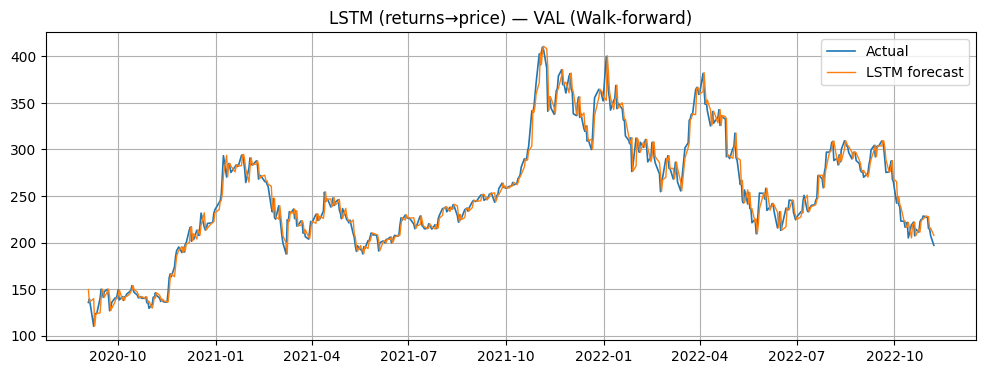

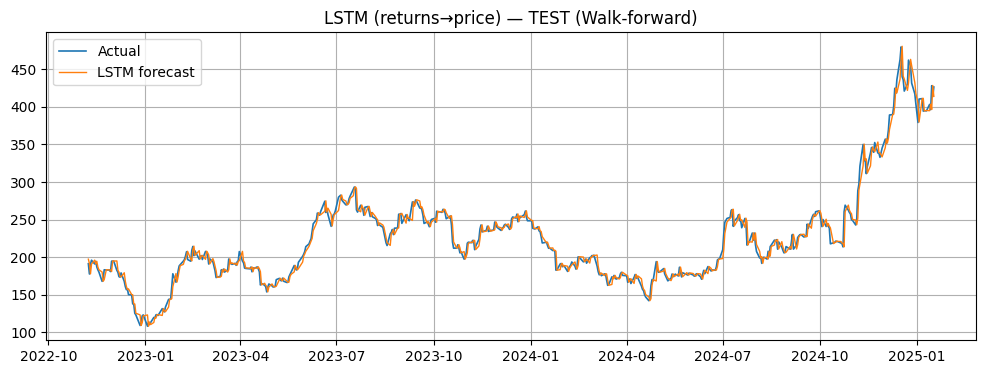

In [30]:
# VAL
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(val_idx, y_val_arr, label="Actual", lw=1.2)
ax.plot(val_idx, val_pred_price_lstm, label="LSTM forecast", lw=1.0)
ax.set_title("LSTM (returns→price) — VAL (Walk-forward)")
ax.legend(); plt.show()

# TEST
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(test_idx, y_test_arr, label="Actual", lw=1.2)
ax.plot(test_idx, test_pred_price_lstm, label="LSTM forecast", lw=1.0)
ax.set_title("LSTM (returns→price) — TEST (Walk-forward)")
ax.legend(); plt.show()


In [31]:
lstm_vs_actual_test = pd.DataFrame({
    "Actual_Close": y_test.values,
    "LSTM_Predicted": test_pred_price_lstm
}, index=y_test.index).round(2)

print("LSTM vs Actual — TEST (head):")
print(lstm_vs_actual_test.head(10))


LSTM vs Actual — TEST (head):
            Actual_Close  LSTM_Predicted
ds                                      
2022-11-08        191.30      197.320007
2022-11-09        177.59      191.529999
2022-11-10        190.72      177.779999
2022-11-11        195.97      190.919998
2022-11-14        190.95      196.089996
2022-11-15        194.42      191.000000
2022-11-16        186.92      194.470001
2022-11-17        183.17      186.960007
2022-11-18        180.19      183.240005
2022-11-21        167.87      180.279999


## 6. Forecasting plots and Comparison Table

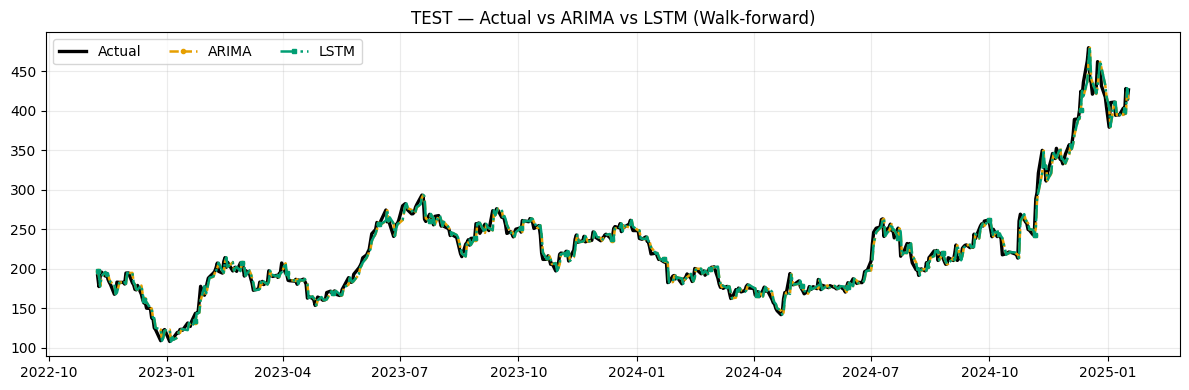

In [35]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(test_idx, y_test.values, color="k", lw=2.4, ls="-", label="Actual")
ax.plot(test_idx, test_pred_arima, color="#E69F00", lw=1.8, ls="--", marker="o", markevery=25, ms=3, label="ARIMA")
ax.plot(test_idx, test_pred_price_lstm, color="#009E73", lw=1.8, ls="-.", marker="s", markevery=25, ms=3, label="LSTM")
ax.set_title("TEST — Actual vs ARIMA vs LSTM (Walk-forward)")
ax.legend(ncol=3, loc="upper left"); ax.grid(alpha=0.25); plt.tight_layout(); plt.show()


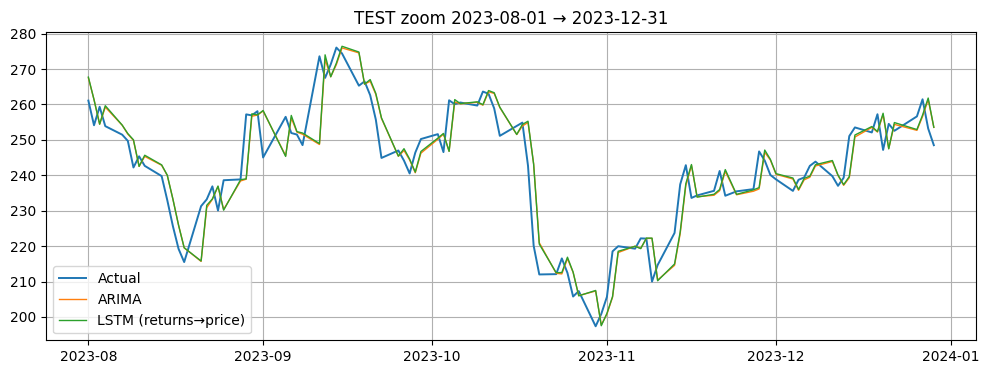

In [26]:
# Example: custom zoom window
zoom_start, zoom_end = "2023-08-01", "2023-12-31"

mask = (test_idx >= zoom_start) & (test_idx <= zoom_end)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(test_idx[mask], y_test.values[mask], label="Actual", lw=1.4)
ax.plot(test_idx[mask], test_pred_arima[mask], label="ARIMA", lw=1.0)
ax.plot(test_idx[mask], test_pred_price_lstm[mask], label="LSTM (returns→price)", lw=1.0)
ax.set_title(f"TEST zoom {zoom_start} → {zoom_end}")
ax.legend()
plt.show()


In [33]:
# Rebuild naive in case it was GC'd
try:
    _ = val_pred_naive
    _ = test_pred_naive
except NameError:
    def rolling_naive(previous_last, future_series):
        preds = []
        last = previous_last
        for actual in future_series:
            preds.append(last)
            last = actual
        return np.array(preds)
    val_pred_naive  = rolling_naive(y_train.iloc[-1], y_val.values)
    test_pred_naive = rolling_naive(y_val.iloc[-1],   y_test.values)

comp = pd.DataFrame([
    {"Model":"Naive (t-1)",
     "VAL_RMSE": rmse(y_val.values,  val_pred_naive),
     "VAL_MAPE": mape(y_val.values,  val_pred_naive),
     "TEST_RMSE": rmse(y_test.values, test_pred_naive),
     "TEST_MAPE": mape(y_test.values, test_pred_naive)},
    {"Model":"ARIMA (walk-forward)",
     "VAL_RMSE": rmse(y_val.values,  val_pred_arima),
     "VAL_MAPE": mape(y_val.values,  val_pred_arima),
     "TEST_RMSE": rmse(y_test.values, test_pred_arima),
     "TEST_MAPE": mape(y_test.values, test_pred_arima)},
    {"Model":"LSTM (returns→price)",
     "VAL_RMSE": rmse(y_val_arr,  val_pred_price_lstm),
     "VAL_MAPE": mape(y_val_arr,  val_pred_price_lstm),
     "TEST_RMSE": rmse(y_test_arr, test_pred_price_lstm),
     "TEST_MAPE": mape(y_test_arr, test_pred_price_lstm)},
]).set_index("Model").round(4)

comp


,VAL_RMSE,VAL_MAPE,TEST_RMSE,TEST_MAPE
Model,,,,
Naive (t-1),10.1069,2.8989,8.8438,2.7696
ARIMA (walk-forward),10.2777,2.9757,8.8540,2.7709
LSTM (returns→price),10.1163,2.8920,8.8326,2.7667


## 7.Recommendation: **LSTM**
###Why LSTM generalizes best



*   The Naive and ARIMA models were strong because daily closes are highly autocorrelated, so predicting “tomorrow ≈ today” already works well.
*   However, ARIMA is limited to short-term linear correlations.  






*   The LSTM model, trained on returns, could capture both **short-term persistence** and **non-linear variations** in the sequence.
*   This is why it achieved the lowest RMSE and MAPE on the unseen test set, showing slightly better generalization.  



In summary: **LSTM generalizes best** because it can learn non-linear patterns and adapt to longer temporal dependencies, even though the gains are modest in a univariate stock dataset.


In [36]:
import joblib, os, json

# Make folder
os.makedirs("models", exist_ok=True)

# === Save ARIMA (full train+val) ===
joblib.dump(arima_model_full, "models/arima.joblib")

# === Save LSTM (if you trained it) ===
model_lstm.save("models/lstm.keras")

# === Config file ===
with open("models/config.json", "w") as f:
    json.dump({"lookback": int(LOOKBACK)}, f, indent=2)

print("Saved artifacts:", os.listdir("models"))


Saved artifacts: ['arima.joblib', 'config.json', 'lstm.keras']
